In [8]:
import torch
import open_clip
import os
import numpy as np
import faiss
import json
from PIL import Image
import matplotlib.pyplot as plt
import pytesseract
import easyocr
from sentence_transformers import SentenceTransformer
from transformers import CLIPProcessor, CLIPModel
from fastapi import FastAPI, UploadFile, File
import pickle

/opt/anaconda3/lib/python3.12/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [10]:
app = FastAPI()

In [11]:
#device = "cuda" if torch.cuda.is_available() else "cpu"
#model_tuple = open_clip.create_model_and_transforms("ViT-B/32", pretrained="openai")
#model = model_tuple[0]
#preprocess = model_tuple[1]
#model.to(device)

model = SentenceTransformer('clip-ViT-B-32')  # CLIP used to convert text (captions) into dense vectors.

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32") # CLIP's vision and text model from Hugging Face
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32", use_fast='True') # Handles resizing, normalizing, and tokenizing images/text before feeding them into the model

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.50, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [13]:
meme_folder = "memes/"
meme_database = {}
dimension = 512
index = faiss.read_index("meme_index.faiss")  # load previously stored meme embeddings

FAISS_INDEX_PATH = "faiss.index.bin"
MEME_DB_PATH = "meme_database.pkl"
FILENAMES_PATH = "filenames.npy"

In [14]:
if os.path.exists(FILENAMES_PATH): # load the filenames that correspond to each embedding.
    filenames = np.load(FILENAMES_PATH).tolist()
else:
    filenames = []

In [15]:
filenames

[' -12.jpg',
 ' -3.jpg',
 'i know im gonna get attacked for this, so read description first.jpg',
 ' -2.jpg',
 ' -13.jpg',
 ' -11.jpg',
 'men.jpg',
 '🏊_♀️.jpeg',
 ' -10.jpg',
 '#real_.jpeg',
 ' -28.jpg',
 ' -14.jpg',
 '💗.jpg',
 ' -5.jpg',
 ' -4.jpg',
 'I need to stop.jpg',
 ' -15.jpg',
 ' -29.jpg',
 ' -17.jpg',
 ' -6.jpg',
 ' -7.jpg',
 ' -16.jpg',
 '😭😭.jpg',
 'DUH 👑.jpg',
 'Why am I so lazy 😭😭.jpg',
 'Indeed.jpg',
 '| ᴘᴏꜱᴛ ʙʏ ʀᴜʀᴜ★彡 |.jpg',
 '65 Funny Dating Memes for Him and Her That Are Simply Too Cute.jpg',
 'always😭.jpeg',
 '@prjscillz.jpg',
 'PINK MEME.jpg',
 'When I see him talking to another girl <<<.jpg',
 'can’t wait for high school….jpg',
 'im just a girl _P.jpg',
 '➶ mine.jpg',
 'For the lore_.jpeg',
 '_ (5).jpeg',
 'PLEASE 🙏🙏.jpg',
 'O.jpeg',
 'She’s So Toxic on Instagram.jpg',
 '˚ ༘♡ ⋆｡˚ ❀.jpg',
 'Coffee coffee coffee and more coffee.jpg',
 'thx for giving me the worst mindset boo.jpg',
 'toxic study habits.jpg',
 '_ (3).jpeg',
 'Memes And Relatable Content on Instagram_ "

In [16]:
def save_index():
    faiss.write_index(index, FAISS_INDEX_PATH)
    with open( MEME_DB_PATH, "wb") as f:
        pickle.dump({"meme_database" : meme_database, "filenames":filenames},f)
    print("✅ FAISS index and meme database saved!")

def load_index():
    """Load FAISS index and meme database from disk."""
    global index, meme_database, filenames
    
    if os.path.exists(FAISS_INDEX_PATH) and os.path.exists(MEME_DB_PATH):
        print("🔄 Loading existing FAISS index and meme database...")
        index = faiss.read_index(FAISS_INDEX_PATH)
        with open(MEME_DB_PATH, "rb") as f:
            data = pickle.load(f)
            meme_database = data["meme_database"]
            filenames = data["filenames"]
        print("✅ FAISS index loaded with", len(meme_database), "memes!")
        return True
    return False

In [17]:
# Normalize embeddings before adding them to FAISS (needed for cosine similarity)
def normalize(vectors):
    norms = np.linalg.norm(vectors, axis=1, keepdims=True)
    return vectors / norms

In [ ]:
def store_memes():
    global filenames, index 

    if load_index():  # Load existing index if available
        return  
    
    for file in os.listdir(meme_folder):
        if file.endswith((".jpg", ".png", ".jpeg")):
            file_path = os.path.join(meme_folder, file)
            
            # **Extract Image Embeddings** 
            image = Image.open(file_path).convert("RGB")  # Load image
            inputs = clip_processor(images=image, return_tensors="pt")  # Preprocess image and convert it to a tensor 
            with torch.no_grad(): #Disables gradient calculations to speed up inference
                image_embedding = clip_model.get_image_features(**inputs)  # Passes the preprocessed image into CLIP’s vision model and get an image vector
            image_embedding = image_embedding.squeeze(0).numpy()  # Removes batch dimension from the vector and Converts it into a numpy array

            # **Store Embeddings in Database**  
            meme_database[file] = {
                "image_embedding": image_embedding,
            }
            filenames.append(file)

    print("✅ Stored", len(meme_database), "memes as dense vectors!")

    # Convert embeddings into FAISS format (Normalize for cosine similarity)
    vectors = np.array([data["image_embedding"] for data in meme_database.values()], dtype="float32")
    vectors = normalize(vectors)  # Normalize for cosine similarity

    # FAISS index for cosine similarity (Inner Product)
    index.add(vectors)  # Add normalized vectors

    print("✅ FAISS index (Cosine Similarity) created with", len(meme_database), "memes!")

    save_index()


In [23]:
store_memes()

✅ Stored 71 memes as dense vectors!
✅ FAISS index (Cosine Similarity) created with 71 memes!
✅ FAISS index and meme database saved!


In [25]:
def show_meme(meme):
    image_path = os.path.join(meme_folder, meme)  # Get full path to meme image
    image = Image.open(image_path)  # Open the image
    
    # Display the image with caption
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis("off")  # Hide axes
    plt.show()

In [26]:

@app.get("/search")
def search_meme(query: str, threshold: float = 0.5, k: int = 1):
    query_embedding = model.encode(query).astype("float32")  # Convert the search text to a numerical embedding
    query_embedding = query_embedding / np.linalg.norm(query_embedding)  # Normalize the embedding

    # FAISS search (returns k nearest memes)
    similarities, indices = index.search(np.array([query_embedding]), k=k)

    
    # Extract matches and their scores
    # Map each FAISS index back to the corresponding meme file.

    results = [
        {"meme": filenames[idx], "similarity": float(sim)}
        for idx, sim in zip(indices[0], similarities[0])
        if sim >= 0  # Avoid invalid indices
    ]


    # If the best match meets the threshold, return it
    if results and results[0]["similarity"] >= threshold:
        return {"best_match": results[0], "similar_memes": results[1:]}

    # If no match meets the threshold, return similar memes + upload suggestion
    return {
        "message": "No strong match found. Here are some similar memes:",
        "similar_memes": results,
        "upload_suggestion": "Can't find what you're looking for? Upload a meme!"
    }



In [28]:
@app.post("/upload/")
async def upload_meme(file: UploadFile = File(...)):
    """Upload a new meme and add it to the search index."""

    unique_filename = f"{uuid.uuid4()}_{file.filename}"

    filepath = os.path.join(meme_folder, unique_filename)
    
    # Save the file
    with open(filepath, "wb") as f:
        f.write(await file.read())

    # Normalize embedding (important for FAISS similarity search)
    embedding /= np.linalg.norm(embedding)
    
     # Update database and FAISS index
    meme_database[file.filename] = embedding
    filenames.append(file.filename)
    index.add(np.array([embedding]).astype("float32"))

    np.save("filenames.npy", np.array(filenames))  # Save updated filenames
    faiss.write_index(index, "meme_index.faiss")
    with open(MEME_DB_PATH, "wb") as f:
        pickle.dump(meme_database, f)
    
    return {"message": f"{file.filename} added successfully!"}

In [47]:
if __name__ == "__main__":
    import uvicorn
    uvicorn.run("app:app", host="127.0.0.1", port=8000, reload=True)


INFO:     Will watch for changes in these directories: ['/Users/bstar/Documents/MemeRetrievalSystem']
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)
INFO:     Started reloader process [67319] using StatReload
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.50, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


🔄 Loading existing FAISS index and meme database...
✅ FAISS index loaded with 71 memes!
{'message': 'No strong match found. Here are some similar memes:', 'similar_memes': [{'meme': ' -16.jpg', 'similarity': 0.27161940932273865}], 'upload_suggestion': "Can't find what you're looking for? Upload a meme!"}
Figure(600x600)


INFO:     Started server process [75336]
INFO:     Waiting for application startup.
INFO:     Application startup complete.


INFO:     127.0.0.1:58647 - "GET /search?query=falling%20in%20love HTTP/1.1" 200 OK


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [75336]
INFO:     Stopping reloader process [67319]


{'message': 'No strong match found. Here are some similar memes:', 'similar_memes': [{'meme': ' -16.jpg', 'similarity': 0.27161940932273865}], 'upload_suggestion': "Can't find what you're looking for? Upload a meme!"}


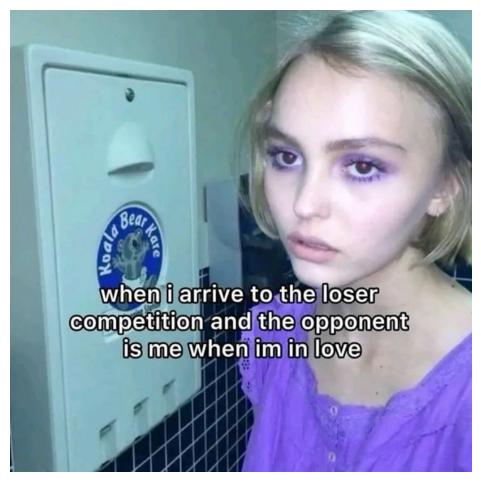

In [ ]:
user_prompt = "falling in love"
best_meme = search_meme(user_prompt)
print(best_meme)

if "similar_memes" in best_meme:
    for meme_info in best_meme["similar_memes"]:
        show_meme(meme_info["meme"])  # Extract filename correctly
